In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow
%matplotlib inline

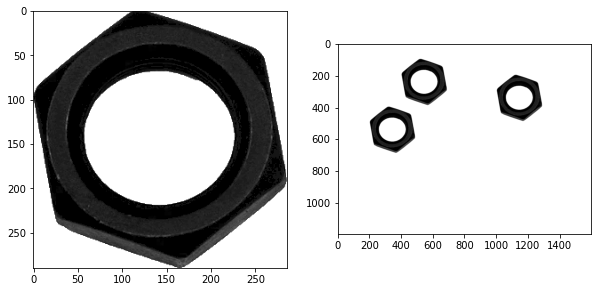

In [4]:
template_im = cv.imread(r'./resources/template.png', cv.IMREAD_GRAYSCALE)
belt_im = cv.imread(r'./resources/belt.png', cv.IMREAD_GRAYSCALE)
fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(template_im, cmap='gray')
ax[1].imshow(belt_im, cmap='gray')
plt.show()

In [5]:
th_t, img_t = cv.threshold(template_im, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
th_b, img_b = cv.threshold(belt_im, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

In [7]:
kernel = np.ones((3,3), dtype=np.uint8)
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel)
closing_b = cv.morphologyEx(img_b, cv.MORPH_CLOSE, kernel)

In [11]:
retval_t, labels_t, stats_t, centroids_t = cv.connectedComponentsWithStats(closing_t)
retval_b, labels_b, stats_b, centroids_b = cv.connectedComponentsWithStats(closing_b)

print(retval_b)
print(" ")
print(stats_b)
print(" ")
print(centroids_b)

4
 
[[      0       0    1600    1200 1798161]
 [    400     100     286     290   40613]
 [   1000     200     286     290   40613]
 [    200     400     286     290   40613]]
 
[[ 807.85728475  614.56805258]
 [ 542.82567158  243.78479797]
 [1142.82567158  343.78479797]
 [ 342.82567158  543.78479797]]


In [49]:
contours_t, hierarchy_t = cv.findContours(closing_t, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours_b, hierarchy_b = cv.findContours(closing_b, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)



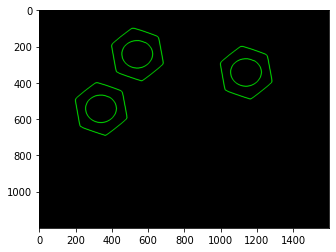

In [50]:
# Visualizing contours
im_contours_belt = np.zeros((belt_im.shape[0],belt_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_belt, contours_b, -1, (0,255,0), 3).astype('uint8')
plt.imshow(conts)

In [51]:
label = 1 # remember that the label of the background is 0
belt = ((labels_b >= label)*255).astype('uint8')
belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
for j,c in enumerate(belt_cont):
    print(cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0))

0.00010071698397173812
0.00010071698397950968
0.00010071698397506879


## Part 2

In [52]:
ca = cv.contourArea(contours_b[1])
M = cv.moments(contours_b[1])
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

print(cx)
print(" ")
print(cy)

341
 
542


In [53]:
count = 1
object_prev_frame = np.array([cx, cy, ca, count])

In [54]:
delta_x = 15
object_curr_frame = np.array([cx, cy, ca, count])

movement_of_cx = object_curr_frame[0] - object_prev_frame[0]

if movement_of_cx < delta_x :
    print("Hey Fucker")

Hey Fucker


## Part 3

In [55]:
def get_indexed_image(im):
    th_im, img_im = cv.threshold(im, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    kernel = np.ones((3,3), dtype=np.uint8)
    closing_im = cv.morphologyEx(img_im, cv.MORPH_CLOSE, kernel)
    retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing_im)


    return retval, labels, stats, centroids

get_indexed_image(belt_im)

(4,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 array([[      0,       0,    1600,    1200, 1798161],
        [    400,     100,     286,     290,   40613],
        [   1000,     200,     286,     290,   40613],
        [    200,     400,     286,     290,   40613]], dtype=int32),
 array([[ 807.85728475,  614.56805258],
        [ 542.82567158,  243.78479797],
        [1142.82567158,  343.78479797],
        [ 342.82567158,  543.78479797]]))

In [56]:
def is_new(a, b, delta, i):
    
    for count_a in range(a.shape[0]):
        for count_i in range(i.shape[0]):
            if np.abs((a[count_a, i[count_i]]) - b[i[count_i]]) > delta[i[count_i]]:
                return False

    return True

In [57]:
 # check is_new expected answer False
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
[7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
[1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])

assert is_new(a, b, delta, i) == False, " Check the function "

In [58]:
def prev_index(a, b, delta, i):
    """ Returns Previous Index
    Returns the index of the apppearance of the object in the previous frame.
    (See thee example in the next cell)
    """
    index = -1
    for count_a in range(a.shape[0]):
        for count_i in range(i.shape[0]):
            if np.abs((a[count_a, i[count_i]]) - b[i[count_i]]) < delta[i[count_i]]:
                index = count_a

    return index

In [67]:
# check prev_index expected answer 1
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
[7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
[1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
# prev_index(a,b,delta,i)
assert prev_index(a,b,delta,i) == 1, " Check the function "